In [1]:
# ✅ Install Kaggle API
# !pip install kaggle

# ✅ Upload kaggle.json
from google.colab import files
files.upload()  # upload your kaggle.json here

# ✅ Move kaggle.json and set permissions
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# # ✅ Download the dataset
# !kaggle datasets download -d lukechugh/best-alzheimer-mri-dataset-99-accuracy

# # ✅ Unzip
# !unzip -q best-alzheimer-mri-dataset-99-accuracy.zip -d alzheimer_dataset


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hitarthdoshi08","key":"76968a54f5acebb346ee643e982166a5"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# ✅ Download the dataset
!kaggle datasets download -d lukechugh/best-alzheimer-mri-dataset-99-accuracy

# ✅ Unzip
!unzip -q best-alzheimer-mri-dataset-99-accuracy.zip -d alzheimer_dataset


Dataset URL: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy
License(s): apache-2.0
  0% 0.00/71.5M [00:00<?, ?B/s]
100% 71.5M/71.5M [00:00<00:00, 1.38GB/s]


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np

# ✅ Constants
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10

# ✅ Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    rotation_range=15
)

train_dir = '/content/alzheimer_dataset/Combined Dataset/train'

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)
# len(train_generator)
# ✅ Build Model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

# ✅ Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.3, verbose=1)
checkpoint = ModelCheckpoint('alz_best_model.h5', monitor='val_loss', save_best_only=True)
steps = int((len(train_generator) / BATCH_SIZE)  )# Steps per epoch

# ✅ Train Model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    # steps_per_epoch=steps,           # ✅ Only 50 steps per epoch
    validation_steps=20           # ✅ Optional: limit validation steps
)


# ✅ Plot Training History
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.show()

Found 8192 images belonging to 4 classes.
Found 2048 images belonging to 4 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


KeyboardInterrupt: 

In [ ]:
from keras.preprocessing.image import load_img, img_to_array

# Alzheimer class labels
alz_class_labels = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

def predict_and_display_alzheimer(img_path, model, image_size=224):
    """
    Predicts Alzheimer's stage from an MRI scan and displays the result.
    If NonDemented, displays 'No Alzheimer's Detected'.
    Otherwise, shows the predicted stage and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Make prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Interpret prediction
        if alz_class_labels[predicted_class_index] == 'NonDemented':
            result = "No Alzheimer's Detected"
        else:
            result = f"Stage: {alz_class_labels[predicted_class_index]}"

        # Display
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


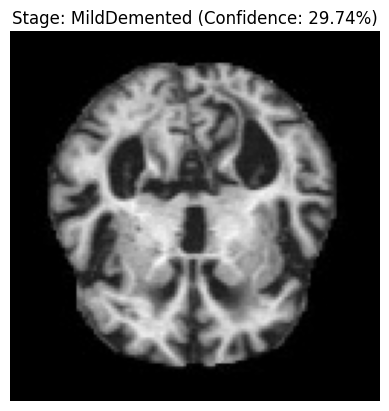

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


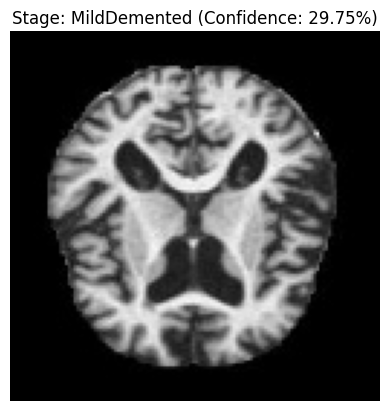

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


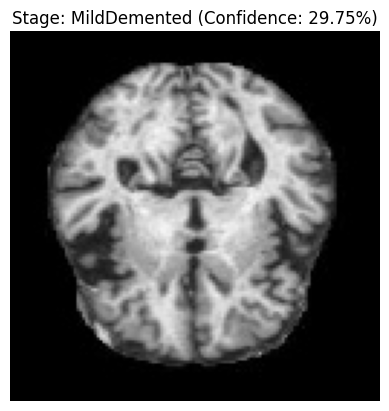

In [ ]:
# Example test image from your dataset
predict_and_display_alzheimer(
    "/content/alzheimer_dataset/Combined Dataset/test/Mild Impairment/1 (11).jpg",
    model
)
# Example test image from your dataset
predict_and_display_alzheimer(
    "/content/alzheimer_dataset/Combined Dataset/test/Moderate Impairment/13 (2).jpg",
    model
)
# Example test image from your dataset
predict_and_display_alzheimer(
    "/content/alzheimer_dataset/Combined Dataset/test/No Impairment/1 (16).jpg",
    model
)


In [ ]:
import os
import numpy as np
import random
from PIL import Image,ImageEnhance
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense,Flatten,Dropout
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle

test_dir='/content/alzheimer_dataset/Combined Dataset/test'
train_dir='/content/alzheimer_dataset/Combined Dataset/train'
train_paths = []
train_labels = []
for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

# Load and shuffle the test data
test_paths = []
test_labels = []
for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)
# len(train_paths)

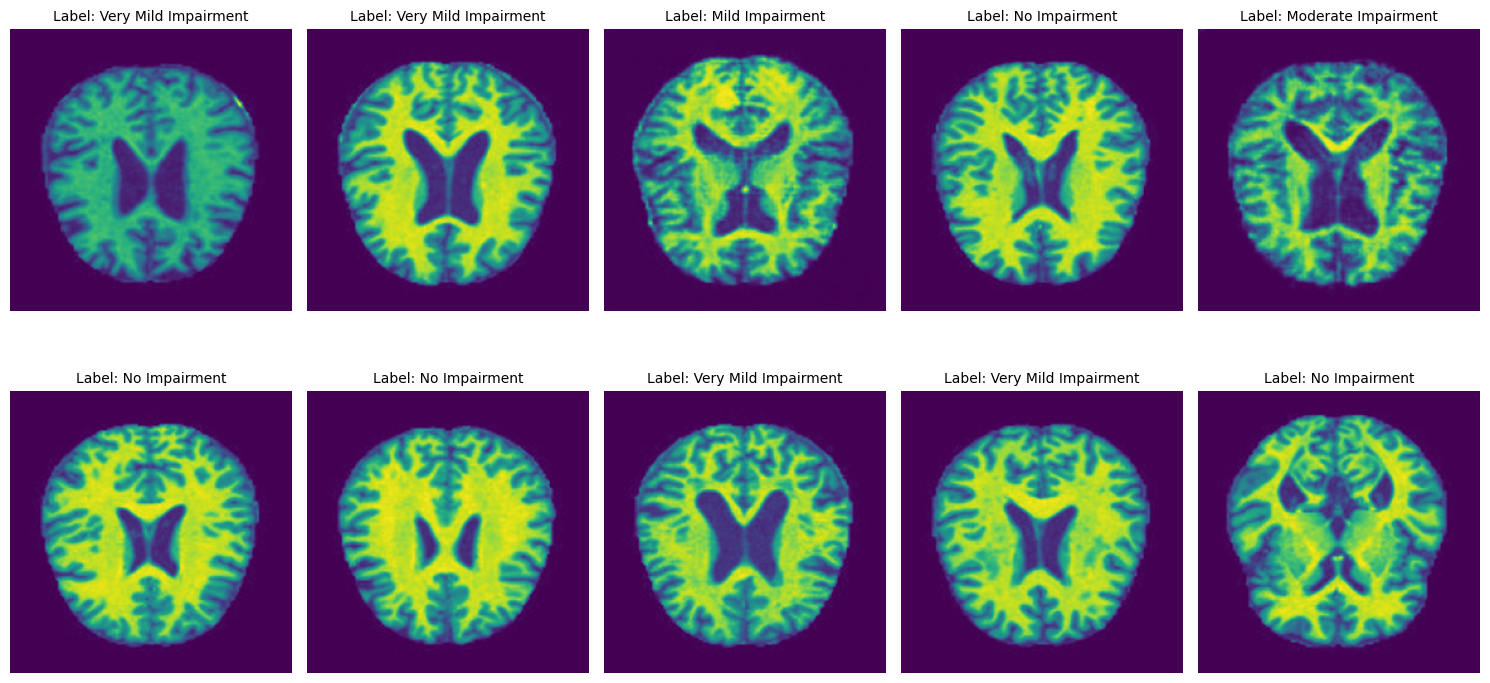

In [ ]:

import random
import matplotlib.pyplot as plt
from PIL import Image
import os


# Select random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)

# Create a figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    # Load image
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((224, 224))  # Resize to consistent size

    # Display image
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axis
    # Display class label in the second row
    axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Random contrast
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image

# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels (convert label names to integers)
def encode_label(labels):
    unique_labels = os.listdir(train_dir)  # Ensure unique labels are determined
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  # Encode labels
            yield batch_images, batch_labels  # Yield the batch

In [ ]:
IMAGE_SIZE = 128  # Image size (adjust based on your requirements)
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers of the VGG16 base model
for layer in base_model.layers:
    layer.trainable = False

# Set the last few layers of the VGG16 base model to be trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Build the final model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))  # Input layer
model.add(base_model)  # Add VGG16 base model
model.add(Flatten())  # Flatten the output of the base model
model.add(Dropout(0.3))  # Dropout layer for regularization
model.add(Dense(128, activation='relu'))  # Dense layer with ReLU activation
model.add(Dropout(0.2))  # Dropout layer for regularization
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))  # Output layer with softmax activation

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Parameters
batch_size = 20
steps = int((len(train_paths)/batch_size))     # Steps per epoch
epochs = 10

# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 37s 55ms/step - loss: 0.9556 - sparse_categorical_accuracy: 0.5457
Epoch 2/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 29s 57ms/step - loss: 0.4430 - sparse_categorical_accuracy: 0.8043
Epoch 3/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 30s 58ms/step - loss: 0.3113 - sparse_categorical_accuracy: 0.8719
Epoch 4/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 29s 57ms/step - loss: 0.2220 - sparse_categorical_accuracy: 0.9112
Epoch 5/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 29s 57ms/step - loss: 0.1873 - sparse_categorical_accuracy: 0.9280
Epoch 6/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 29s 57ms/step - loss: 0.1223 - sparse_categorical_accuracy: 0.9524
Epoch 7/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 29s 57ms/step - loss: 0.0923 - sparse_categorical_accuracy: 0.9654
Epoch 8/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 29s 57ms/step - loss: 0.0518 - sparse_categorical_accuracy: 0.9829
Epoch 9/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 29s 57ms/step - loss: 0.0434 - sparse_categorical_acc

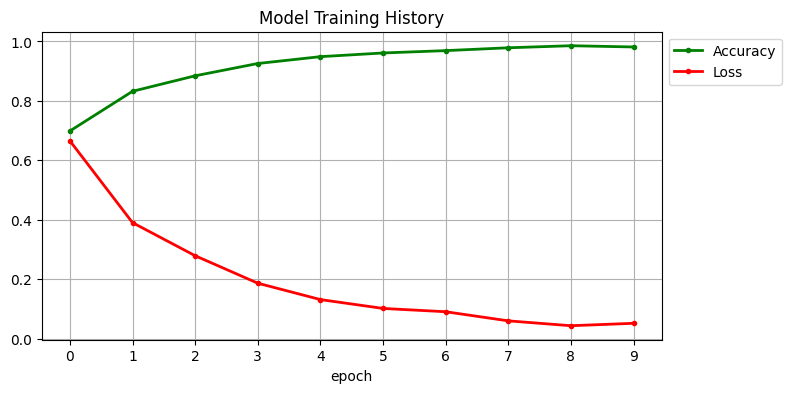

In [ ]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['Moderate Impairment', 'No Impairment', 'Mild Impairment', 'Very Mild Impairment']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'No Impairment':
            result = "No Impairment"
        else:
            result = f"Demented: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


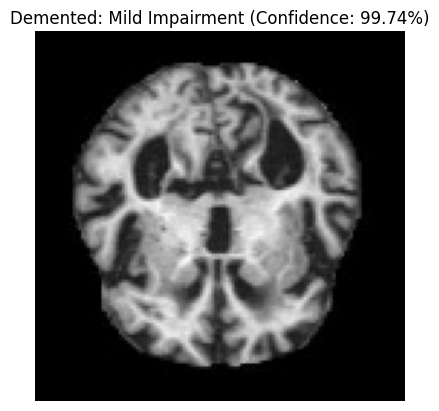

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


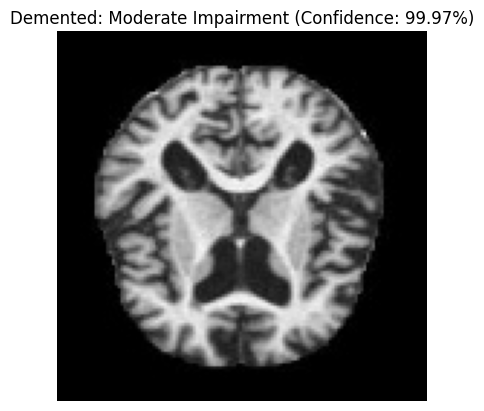

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


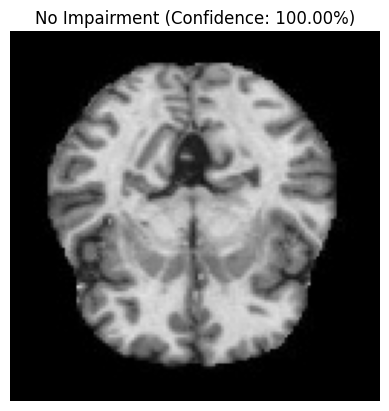

In [ ]:
# Example test image from your dataset
detect_and_display(
    "/content/alzheimer_dataset/Combined Dataset/test/Mild Impairment/1 (11).jpg",
    model
)
# Example test image from your dataset
detect_and_display(
    "/content/alzheimer_dataset/Combined Dataset/test/Moderate Impairment/13 (2).jpg",
    model
)
# # Example test image from your dataset
detect_and_display(
    "/content/alzheimer_dataset/Combined Dataset/test/No Impairment/1 (35).jpg",
    model
)


In [ ]:
def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect impairment and display results.
    If no impairment is detected, it displays "No Impairment".
    Otherwise, it shows the predicted class and confidence.
    """
    try:
        # Load and preprocess image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Predict
        predictions = model.predict(img_array)
        predicted_class_index = int(np.argmax(predictions))
        confidence_score = float(np.max(predictions))

        predicted_label = class_labels[predicted_class_index]

        # Interpret result
        dementia_labels = ['Mild Impairment', 'Moderate Impairment', 'Very Mild Impairment']
        if predicted_label in dementia_labels:
            result = f"Demented: {predicted_label}"
        else:
            result = "No Impairment"

        # Display
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))


In [ ]:
detect_and_display(
    "/content/alzheimer_dataset/Combined Dataset/test/Mild Impairment/10 (12).jpg",
    model
)

NameError: name 'detect_and_display' is not defined

Confusion Matrix:
[[ 12   0   0   0]
 [  0 629   1  10]
 [  1   6 169   3]
 [  1  28   2 417]]


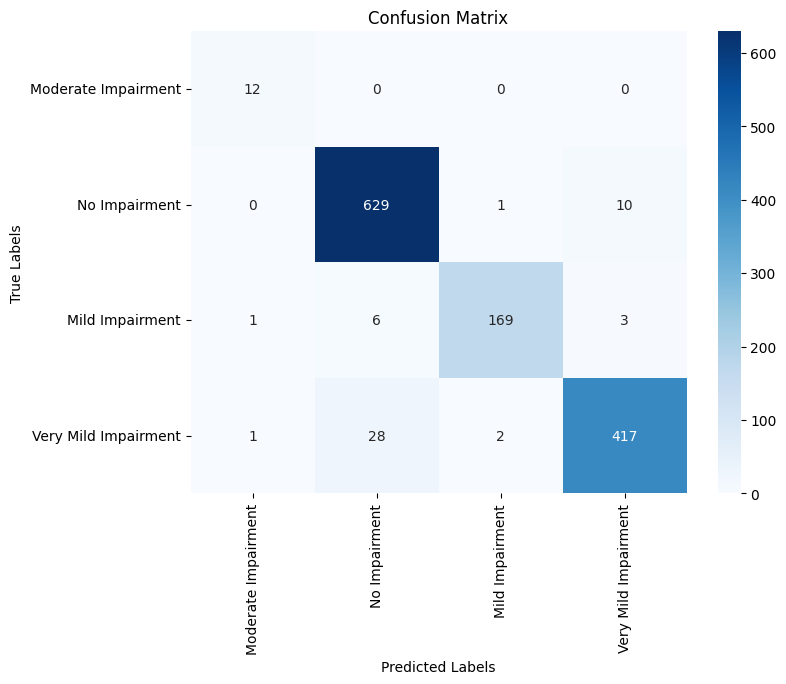

In [ ]:
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

# 1. Prediction on test data
test_images = open_images(test_paths)  # Load and augment test images
test_labels_encoded = encode_label(test_labels)  # Encode the test labels

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 206ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92        12
           1       0.95      0.98      0.97       640
           2       0.98      0.94      0.96       179
           3       0.97      0.93      0.95       448

    accuracy                           0.96      1279
   macro avg       0.94      0.96      0.95      1279
weighted avg       0.96      0.96      0.96      1279



In [ ]:
model.save('alzhemeir.h5')  # Save to HDF5 format


In [ ]:
from google.colab import files
files.download('alzhemeir.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>